<a href="https://colab.research.google.com/github/miltiadiss/Decision-Theory/blob/main/TSLA_stock_price_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

import os
desired_directory = '/content/drive/MyDrive/alphavantage' #define current directory in google drive
os.chdir(desired_directory)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [49]:
import requests

#API_KEY = YZFYJ9DASTWXPXOS
#STOCK_SYMBOL = TSLA

url = 'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=TSLA&outputsize=full&apikey=YZFYJ9DASTWXPXOS'
r = requests.get(url)
json_data = r.json()

#print(json_data)

Data saved to close_prices.csv


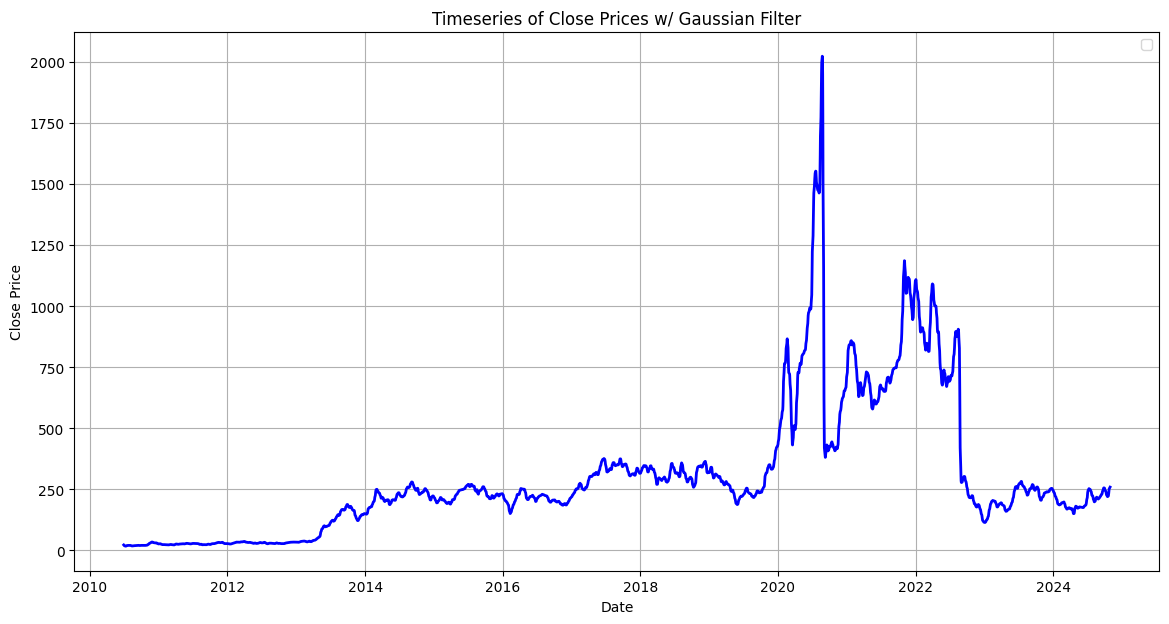

In [50]:
import json
import csv
import pandas as pd
from scipy.ndimage import gaussian_filter1d
import numpy as np

# Extract "Time Series (Daily)" part from JSON
time_series = json_data.get("Time Series (Daily)", {})

# Prepare data for CSV
csv_data = [("Date", "Close")]  # Header for CSV file

# Loop through each date and get the "close" price
for date, daily_data in time_series.items():
    close_price = daily_data.get("4. close", None)
    if close_price:
        csv_data.append((date, close_price))

# Write data to CSV file
csv_file = 'close_prices.csv'
with open(csv_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(csv_data)

print(f"Data saved to {csv_file}")

# Read CSV file and store the data in a DataFrame
df = pd.read_csv('close_prices.csv', parse_dates=['Date'])
df = df.sort_values(by='Date')  # Sorting by 'Date'

# Apply Gaussian Filter in 'Close' prices for smoothing
sigma = 2
df['Close'] = gaussian_filter1d(df['Close'], sigma=sigma)

# Plot the smoothed timeseries
plt.figure(figsize=(14, 7))
plt.plot(df['Date'], df['Close'], color='blue', linewidth=2)

plt.title('Timeseries of Close Prices w/ Gaussian Filter')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()

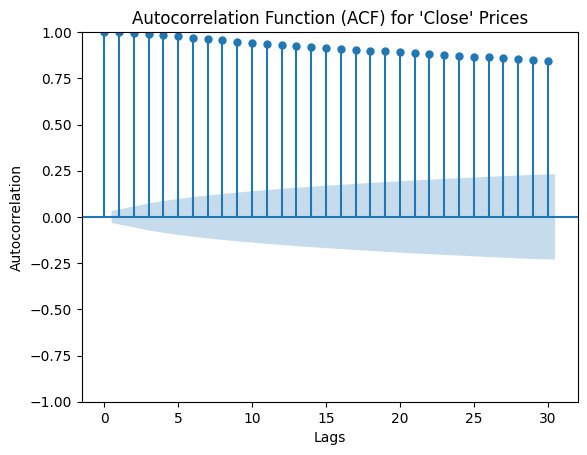

In [27]:
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

# Create ACF plot to find related lags
plot_acf(df['Close'], lags=30)
plt.title("Autocorrelation Function (ACF) for 'Close' Prices")
plt.xlabel("Lags")
plt.ylabel("Autocorrelation")
plt.show()


Model Parameters for N=1:
Intercept: 0.5329
Coefficient for close_t-1: 0.9986
Model Equation:
Close_t = 0.5329 + (0.9986) * close_t-1

Model Parameters for N=2:
Intercept: 0.7880
Coefficient for close_t-1: 1.9375
Coefficient for close_t-2: -0.9399
Model Equation:
Close_t = 0.7880 + (1.9375) * close_t-1 + (-0.9399) * close_t-2

Model Parameters for N=3:
Intercept: 0.1017
Coefficient for close_t-1: 2.7733
Coefficient for close_t-2: -2.6627
Coefficient for close_t-3: 0.8890
Model Equation:
Close_t = 0.1017 + (2.7733) * close_t-1 + (-2.6627) * close_t-2 + (0.8890) * close_t-3

Model Parameters for N=4:
Intercept: 0.1595
Coefficient for close_t-1: 3.4858
Coefficient for close_t-2: -4.7963
Coefficient for close_t-3: 3.1111
Coefficient for close_t-4: -0.8011
Model Equation:
Close_t = 0.1595 + (3.4858) * close_t-1 + (-4.7963) * close_t-2 + (3.1111) * close_t-3 + (-0.8011) * close_t-4

Model Parameters for N=5:
Intercept: 0.0374
Coefficient for close_t-1: 4.1239
Coefficient for close_t-2: -7.2

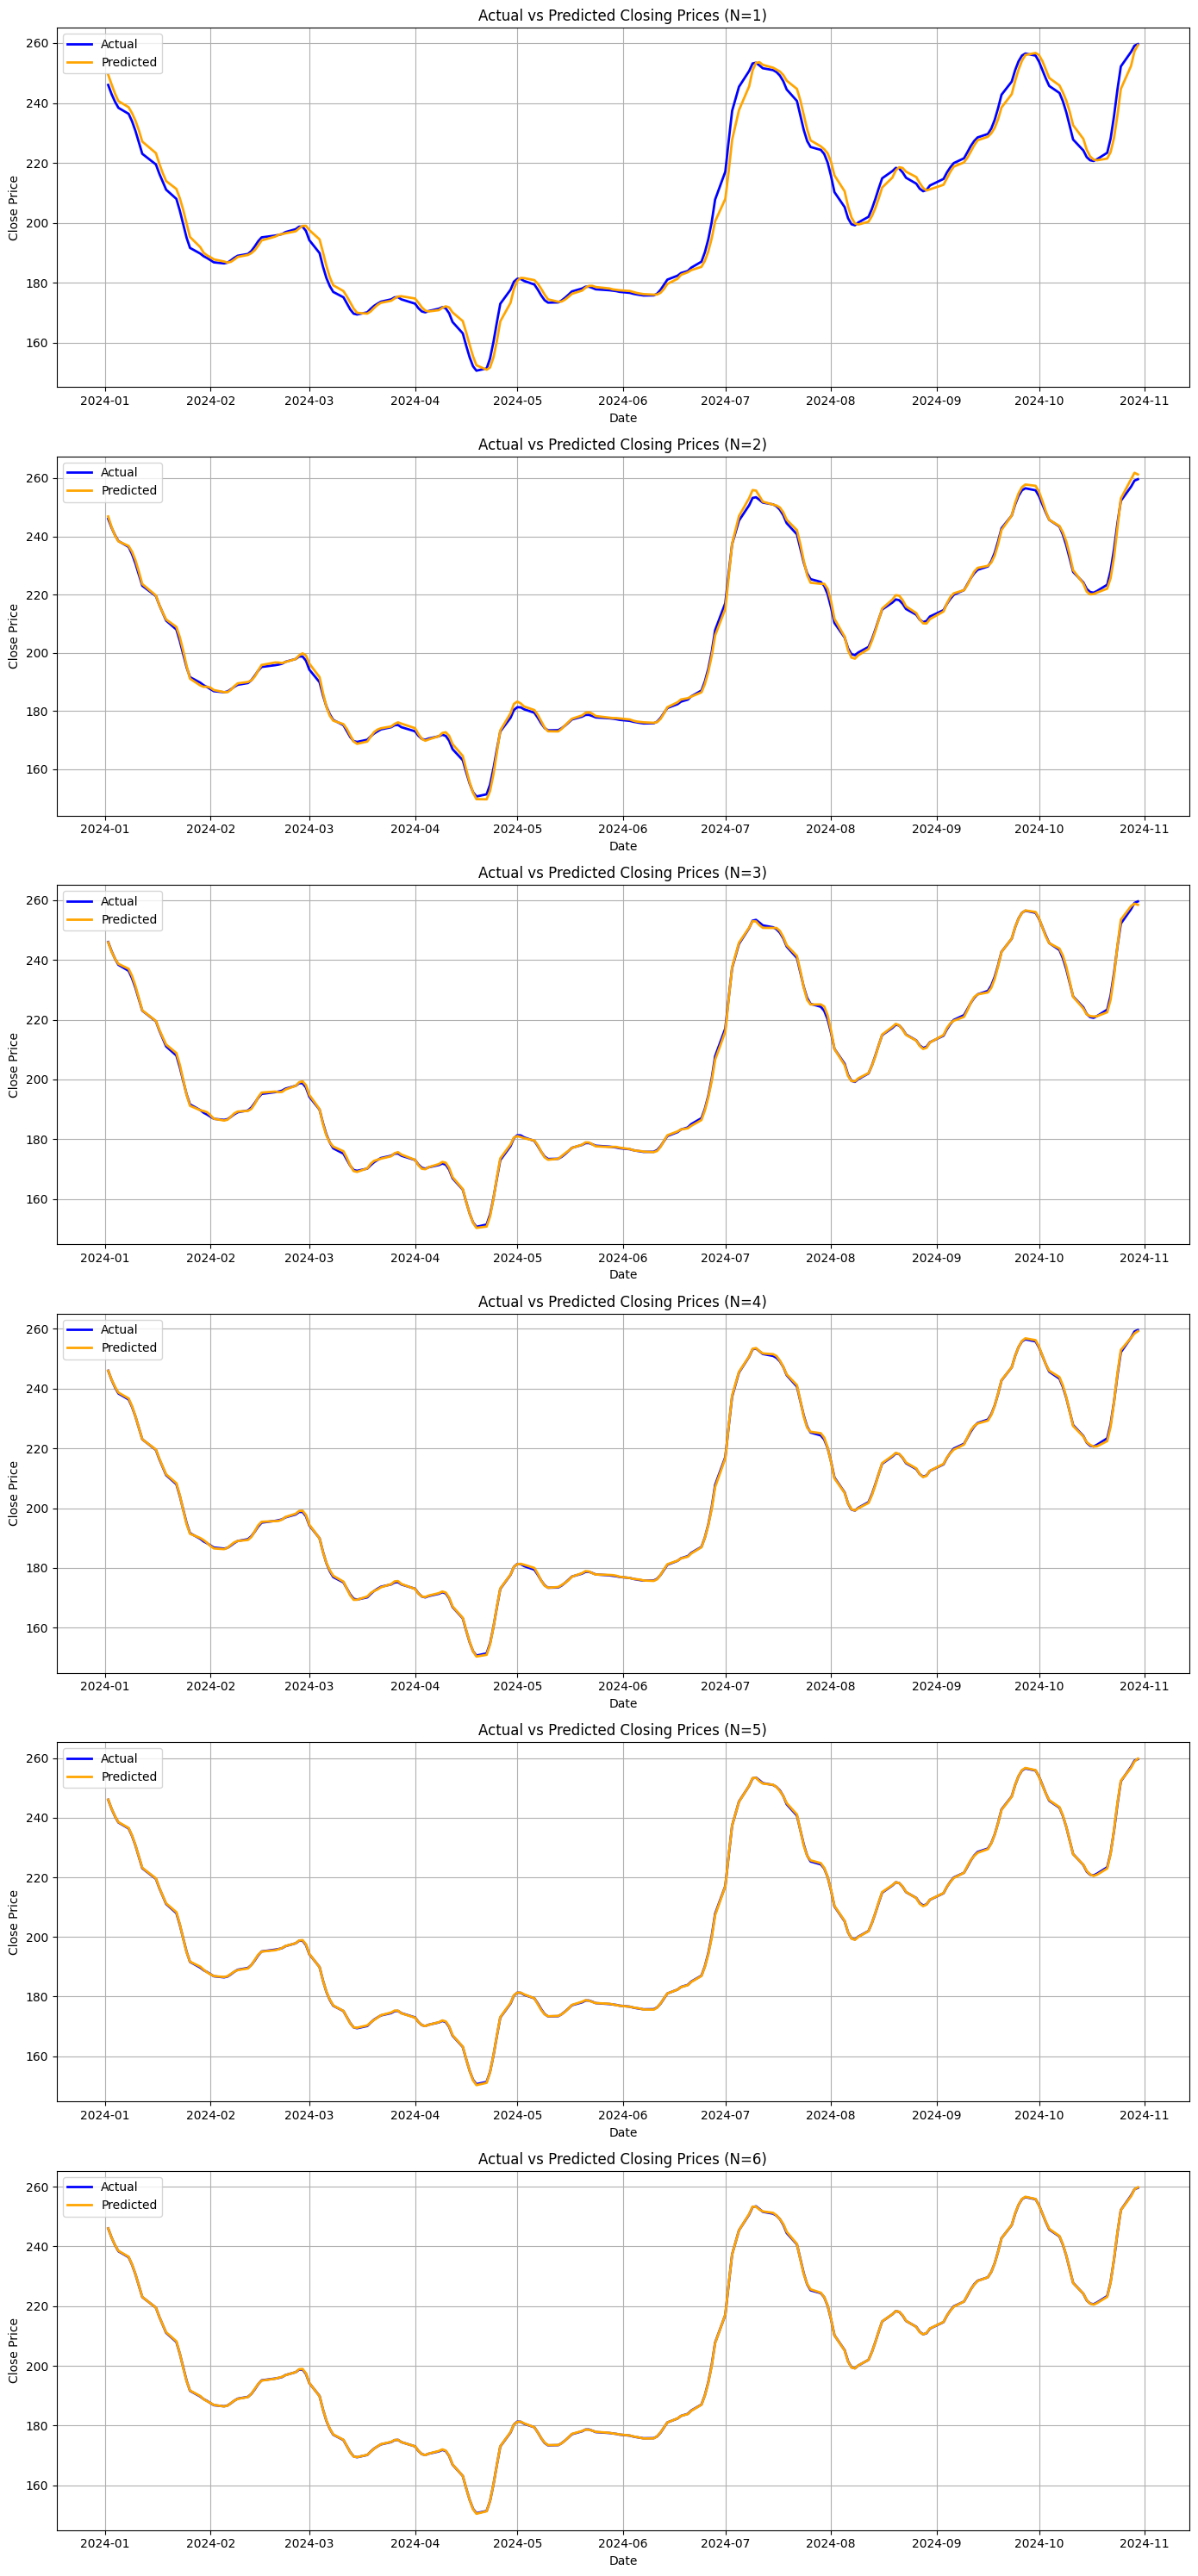

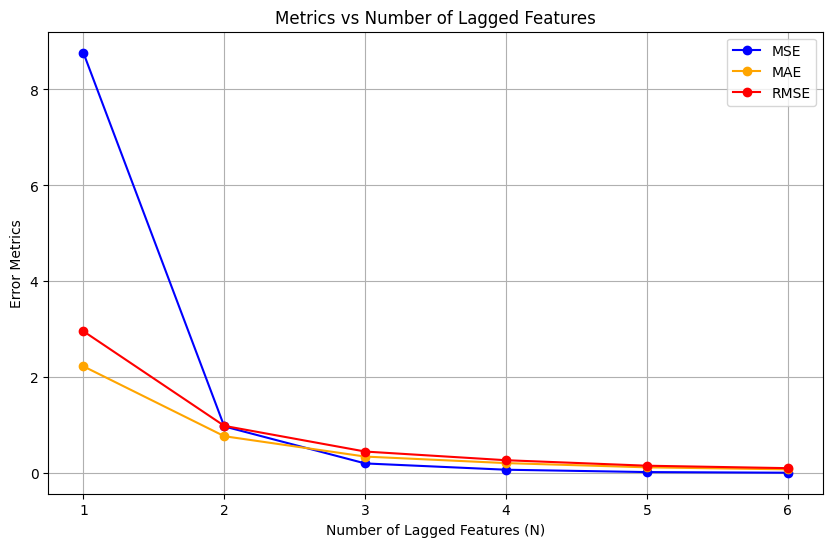

In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Create a function that trains and evaluates the model for different amounts
# of lagged features and different DataFrames
def train_and_evaluate_model(N, data):
    # Create N lagged features
    for i in range(1, N + 1):
        data[f'close_t-{i}'] = data['Close'].shift(i)

    # Drop NaN values
    data.dropna(inplace=True)

    # Create training set and validation set
    train_data = data[data['Date'] < '2024-01-01']  # Use previous years for training
    validation_data = data[data['Date'] >= '2024-01-01']  # Use year 2024 for validation

    # Prepare features (X) and target (y) for training and validation
    X_train = train_data[[f'close_t-{i}' for i in range(1, N + 1)]]
    y_train = train_data['Close']
    X_val = validation_data[[f'close_t-{i}' for i in range(1, N + 1)]]
    y_val = validation_data['Close']

    # Create and fit the Linear Regression model using the training set
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Make the prediction using the validation set
    y_pred = model.predict(X_val)

    # Evaluate the model metrics
    mae = mean_absolute_error(y_val, y_pred)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    mse = mean_squared_error(y_val, y_pred)

    # Get model coefficients a, b, ε
    coefficients = model.coef_
    intercept = model.intercept_

    return mae, rmse, mse, y_val, y_pred, validation_data['Date'], coefficients, intercept

# Plot the actual and predicted 'close' prices for the different values of lagged features and
# the initial DataFrame
num_tests = 6  # Testing from N = 1 to 6
fig, axes = plt.subplots(num_tests, 1, figsize=(14, 5 * num_tests))
results = []

for idx, N in enumerate(range(1, num_tests + 1)):
    mae, rmse, mse, y_val, y_pred, dates, coefficients, intercept = train_and_evaluate_model(N, df)  # Call the function here
    results.append((N, mae, rmse, mse))

    axes[idx].plot(dates, y_val, label='Actual', color='blue', linewidth=2)
    axes[idx].plot(dates, y_pred, label='Predicted', color='orange', linewidth=2)
    axes[idx].set_title(f'Actual vs Predicted Closing Prices (N={N})')
    axes[idx].set_xlabel('Date')
    axes[idx].set_ylabel('Close Price')
    axes[idx].legend()
    axes[idx].grid(True)

    # Print the model coefficients
    print(f"\nModel Parameters for N={N}:")
    print(f"Intercept: {intercept:.4f}")
    equation = f"Close_t = {intercept:.4f}"
    for i, coef in enumerate(coefficients):
        equation += f" + ({coef:.4f}) * close_t-{i+1}"
        print(f"Coefficient for close_t-{i+1}: {coef:.4f}")
    print("Model Equation:")
    print(equation)

results_df = pd.DataFrame(results, columns=['N', 'Mean Absolute Error', 'Root Mean Squared Error', 'Mean Squared Error'])
print('\nMetrics')
print(results_df)

plt.tight_layout()
plt.show()

# Plot Metrics vs Number of Lagged Features
plt.figure(figsize=(10, 6))
mse_values = results_df['Mean Squared Error']
mae_values = results_df['Mean Absolute Error']
rmse_values = results_df['Root Mean Squared Error']

plt.plot(range(1, num_tests + 1), mse_values, marker='o', linestyle='-', color='blue', label='MSE')
plt.plot(range(1, num_tests + 1), mae_values, marker='o', linestyle='-', color='orange', label='MAE')
plt.plot(range(1, num_tests + 1), rmse_values, marker='o', linestyle='-', color='red', label='RMSE')

plt.title('Metrics vs Number of Lagged Features')
plt.xlabel('Number of Lagged Features (N)')
plt.ylabel('Error Metrics')
plt.xticks(range(1, num_tests + 1))
plt.legend()
plt.grid(True)
plt.show()